In [1]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

In [2]:
import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg

In [3]:
__all__ = ['KitaevLadder', 'KitaevLadderModel']

In [13]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        Lattice.__init__(self, [L], sites, **kwargs)
        
        
class KitaevLadderModel(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', None, self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jx = get_parameter(model_params, 'Jx', 1., self.name, True)
        Jy = get_parameter(model_params, 'Jy', 1., self.name, True)
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sz', u2, 'Sz', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(-Jx, u1, 'Sx', u2, 'Sx', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
         
        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


In [14]:
def run():
    chi_list = np.arange(16, 50, 2)

    model_params = dict(conserve=None, Jx=1., Jy=1., Jz=1., L=2, verbose=1)
    prod_state = ["up", "down"] * (2 * model_params['L'])
    M = KitaevLadderModel(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
        'mixer': True,  # setting this to True helps to escape local minima
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-6,
        'max_sweeps': 150,
        'verbose': 1.,
    }
    
    print("=" * 100)
    
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    data = dict(entropy_list=[], correlation_list=[])
    for chi in chi_list:
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        eng.run()
        eng.engine_params['mixer'] = None
        psi.canonical_form()
        
        entropy = np.mean(psi.entanglement_entropy())
        correlation = psi.correlation_length()

        data['entropy_list'].append(entropy)
        data['correlation_list'].append(correlation)
        tenpy.tools.optimization.optimize(3)
        pass
        
    return data


def plot_results(data):

    plt.figure()
    ax = plt.gca()
    ax.plot(data['ent_spectrum'], marker='o')
    ax.set_xlabel(r"DMRG Step")
    ax.set_ylabel(r"$ E $")
    plt.savefig("KitaevLadderModel.pdf")


In [15]:
data = run()
# plot_results(data)
print(data)

parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=2 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=1.0 for KitaevLadderModel
parameter 'Jz'=1.0 for KitaevLadderModel
parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
Initial sweeps...
Updating environment
..........
parameter 'max_sweeps'=150 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-06 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:124: UserWarning: unused parameters for Sweep mixer_params:
['amplitude', 'decay', 'disable_after']
  warnings.warn(msg.format(keys=sorted(unused), descr=warn))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:124: UserWarning: unused parameters for Sweep:
['max_E_err', 'max_S_err', 'max_sweeps', 'mixer', 'mixer_params']
  warnings.warn(msg.format(keys=sorted(unused), descr=warn))


Updating environment
.....
sweep 10, age = 408
Energy = -0.2097005543799209, S = nan, norm_err = 1.8e-08
Current memory usage 190.5 MB, time elapsed: 4.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5800e-06, max_E_trunc = 1.3231e-06
MPS bond dimensions: [16, 16, 16, 16, 16, 16, 16, 16]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097005536675587, S = nan, norm_err = 3.0e-09
Current memory usage 190.5 MB, time elapsed: 8.0 s
Delta E = 7.1236e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5765e-06, max_E_trunc = 1.3249e-06
MPS bond dimensions: [16, 16, 16, 16, 16, 16, 16, 16]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 888
Energy = -0.2097005535489673, S = 1.2231370488123785, norm_err = 2.6e-15
Current memory usage 190.5 MB, time elapsed: 9.9 s
Delta E = 1.1859e-11, Delta S = nan (per sweep)
max_trunc_err = 7.8813e-07, max_E_trunc = 1.3251e-06
MPS bond dimensions: [

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464080974, S = 0.5300859892315385, norm_err = 2.6e-15
Current memory usage 190.5 MB, time elapsed: 2.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.4585e-11, max_E_trunc = 1.4769e-10
MPS bond dimensions: [18, 18, 18, 18, 18, 18, 18, 18]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464120311, S = 0.5300859969192029, norm_err = 2.7e-15
Current memory usage 190.5 MB, time elapsed: 4.2 s
Delta E = -3.9337e-13, Delta S = 7.6877e-10 (per sweep)
max_trunc_err = 7.8151e-11, max_E_trunc = 1.3490e-10
MPS bond dimensions: [18, 18, 18, 18, 18, 18, 18, 18]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 18
Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464772607, S = 0.5300860462759727, norm_err = 2.9e-15
Current memory usage 190.7 MB, time elapsed: 2.3 s
Delta E = 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464806891, S = 0.5300860483549861, norm_err = 2.7e-15
Current memory usage 190.7 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.5370e-12, max_E_trunc = 4.1211e-12
MPS bond dimensions: [24, 24, 24, 24, 24, 24, 24, 24]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464806838, S = 0.5300860483370360, norm_err = 2.0e-15
Current memory usage 190.7 MB, time elapsed: 5.5 s
Delta E = 5.3291e-16, Delta S = -1.7950e-12 (per sweep)
max_trunc_err = 1.5382e-12, max_E_trunc = 4.2633e-12
MPS bond dimensions: [24, 24, 24, 24, 24, 24, 24, 24]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 24


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464820640, S = 0.5300860491135162, norm_err = 1.8e-15
Current memory usage 190.7 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.7781e-13, max_E_trunc = 1.5206e-12
MPS bond dimensions: [26, 26, 26, 26, 26, 26, 26, 26]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464820853, S = 0.5300860491134856, norm_err = 2.5e-15
Current memory usage 190.7 MB, time elapsed: 5.8 s
Delta E = -2.1316e-15, Delta S = -3.0642e-15 (per sweep)
max_trunc_err = 7.7781e-13, max_E_trunc = 1.5774e-12
MPS bond dimensions: [26, 26, 26, 26, 26, 26, 26, 26]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 26


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464826946, S = 0.5300860499489854, norm_err = 2.1e-15
Current memory usage 190.7 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.8482e-14, max_E_trunc = 3.2685e-13
MPS bond dimensions: [28, 28, 28, 28, 28, 28, 28, 28]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827248, S = 0.5300860499539379, norm_err = 9.4e-15
Current memory usage 190.7 MB, time elapsed: 5.3 s
Delta E = -3.0198e-15, Delta S = 4.9525e-13 (per sweep)
max_trunc_err = 3.9891e-14, max_E_trunc = 3.4106e-13
MPS bond dimensions: [28, 28, 28, 28, 28, 28, 28, 28]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 28


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827239, S = 0.5300860499713780, norm_err = 2.5e-15
Current memory usage 190.7 MB, time elapsed: 2.7 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.1182e-14, max_E_trunc = 2.4158e-13
MPS bond dimensions: [30, 30, 30, 30, 30, 30, 30, 30]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464826680, S = 0.5300860499715246, norm_err = 1.9e-15
Current memory usage 190.7 MB, time elapsed: 5.4 s
Delta E = 5.5955e-15, Delta S = 1.4666e-14 (per sweep)
max_trunc_err = 3.1167e-14, max_E_trunc = 4.1211e-13
MPS bond dimensions: [30, 30, 30, 30, 30, 30, 30, 30]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 30


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827381, S = 0.5300860499883098, norm_err = 2.6e-15
Current memory usage 190.7 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 2.2737e-14, max_E_trunc = 1.7053e-13
MPS bond dimensions: [32, 32, 32, 32, 32, 32, 32, 32]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827301, S = 0.5300860499883148, norm_err = 2.3e-15
Current memory usage 190.7 MB, time elapsed: 5.5 s
Delta E = 7.9936e-16, Delta S = 4.9960e-16 (per sweep)
max_trunc_err = 2.2737e-14, max_E_trunc = 3.9790e-13
MPS bond dimensions: [32, 32, 32, 32, 32, 32, 32, 32]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 32


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827053, S = 0.5300860499992113, norm_err = 2.4e-15
Current memory usage 190.7 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.5060e-14, max_E_trunc = 1.4211e-13
MPS bond dimensions: [34, 34, 34, 34, 34, 34, 34, 34]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827266, S = 0.5300860499991336, norm_err = 2.1e-15
Current memory usage 190.7 MB, time elapsed: 5.7 s
Delta E = -2.1316e-15, Delta S = -7.7716e-15 (per sweep)
max_trunc_err = 1.5060e-14, max_E_trunc = 2.5580e-13
MPS bond dimensions: [34, 34, 34, 34, 34, 34, 34, 34]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 34


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827719, S = 0.5300860500096880, norm_err = 2.5e-15
Current memory usage 190.7 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.7495e-15, max_E_trunc = 1.1369e-13
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827728, S = 0.5300860500115399, norm_err = 3.0e-15
Current memory usage 190.7 MB, time elapsed: 6.0 s
Delta E = -8.8818e-17, Delta S = 1.8519e-13 (per sweep)
max_trunc_err = 7.7757e-15, max_E_trunc = 2.4158e-13
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 36


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827710, S = 0.5300860500234506, norm_err = 2.5e-15
Current memory usage 190.7 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 4.6957e-16, max_E_trunc = 9.9476e-14
MPS bond dimensions: [38, 38, 38, 38, 38, 38, 38, 38]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464828083, S = 0.5300860500235005, norm_err = 2.0e-15
Current memory usage 190.7 MB, time elapsed: 9.4 s
Delta E = -3.7303e-15, Delta S = 4.9960e-15 (per sweep)
max_trunc_err = 4.8457e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [38, 38, 38, 38, 38, 38, 38, 38]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 38


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827817, S = 0.5300860500237279, norm_err = 3.7e-15
Current memory usage 190.7 MB, time elapsed: 4.5 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.9679e-16, max_E_trunc = 1.8474e-13
MPS bond dimensions: [39, 40, 40, 40, 40, 40, 40, 40]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827905, S = 0.5300860500237345, norm_err = 2.6e-15
Current memory usage 190.7 MB, time elapsed: 8.0 s
Delta E = -8.8818e-16, Delta S = 6.6613e-16 (per sweep)
max_trunc_err = 3.9571e-16, max_E_trunc = 2.7001e-13
MPS bond dimensions: [40, 40, 40, 40, 40, 40, 40, 40]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 40


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827728, S = 0.5300860500239652, norm_err = 2.3e-15
Current memory usage 190.7 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.1031e-16, max_E_trunc = 5.6843e-14
MPS bond dimensions: [41, 42, 41, 42, 41, 42, 41, 42]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827603, S = 0.5300860500239772, norm_err = 2.2e-15
Current memory usage 190.7 MB, time elapsed: 7.4 s
Delta E = 1.2434e-15, Delta S = 1.1990e-15 (per sweep)
max_trunc_err = 3.1033e-16, max_E_trunc = 2.5580e-13
MPS bond dimensions: [41, 42, 41, 42, 41, 42, 41, 42]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 42


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827399, S = 0.5300860500242686, norm_err = 2.4e-15
Current memory usage 190.7 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 2.2850e-16, max_E_trunc = 4.2633e-14
MPS bond dimensions: [42, 44, 42, 44, 42, 44, 42, 44]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827337, S = 0.5300860500242465, norm_err = 2.9e-15
Current memory usage 190.7 MB, time elapsed: 8.4 s
Delta E = 6.2172e-16, Delta S = -2.2093e-15 (per sweep)
max_trunc_err = 2.2850e-16, max_E_trunc = 1.8474e-13
MPS bond dimensions: [42, 44, 42, 44, 42, 44, 42, 44]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 44


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827390, S = 0.5300860500242962, norm_err = 2.5e-15
Current memory usage 191.4 MB, time elapsed: 4.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.5165e-16, max_E_trunc = 5.6843e-14
MPS bond dimensions: [44, 46, 44, 46, 44, 46, 44, 46]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827284, S = 0.5300860500242968, norm_err = 2.2e-15
Current memory usage 191.4 MB, time elapsed: 7.9 s
Delta E = 1.0658e-15, Delta S = 5.5511e-17 (per sweep)
max_trunc_err = 1.5165e-16, max_E_trunc = 2.5580e-13
MPS bond dimensions: [44, 46, 44, 46, 44, 46, 44, 46]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 46


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827586, S = 0.5300860500245629, norm_err = 2.6e-15
Current memory usage 191.4 MB, time elapsed: 4.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.7930e-17, max_E_trunc = 8.5265e-14
MPS bond dimensions: [46, 48, 46, 48, 46, 48, 46, 48]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827444, S = 0.5300860500245810, norm_err = 2.0e-15
Current memory usage 191.4 MB, time elapsed: 8.0 s
Delta E = 1.4211e-15, Delta S = 1.8097e-15 (per sweep)
max_trunc_err = 7.8259e-17, max_E_trunc = 1.4211e-13
MPS bond dimensions: [46, 48, 46, 48, 46, 48, 46, 48]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 48


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


{'entropy_list': [0.9955880641963268, 0.5300859969192031, 0.5300860465170838, 0.5300860472660682, 0.5300860483370078, 0.5300860491134538, 0.5300860499539048, 0.530086049971471, 0.5300860499882794, 0.5300860499991136, 0.5300860500115167, 0.5300860500234442, 0.5300860500236884, 0.5300860500239328, 0.5300860500241948, 0.5300860500242257, 0.5300860500245144], 'correlation_list': [2.4729480821082865, 1.8776045185642138, 1.9157227292911188, 1.917267614169005, 1.9174086552680818, 1.9185219064394838, 1.9381589398407424, 1.9382629772875084, 1.9383771873498221, 1.9386671694321125, 1.9568482451089575, 1.9687913309507397, 1.9684313226259316, 1.9696695438912541, 1.9696066095120255, 1.9696884791021594, 1.969761745610054]}


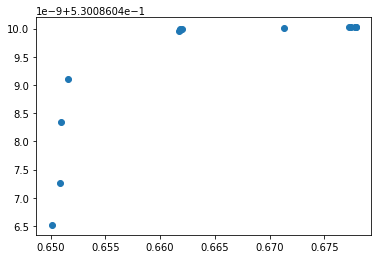

In [16]:
entropy_list = data['entropy_list'][2:-1]
correlation_list = data['correlation_list'][2:-1]
plt.plot(np.log(correlation_list), entropy_list, 'o')

In [8]:
from scipy.optimize import curve_fit

def func(xi, c, a):
    return (c / 6) * np.log(xi) + a

In [9]:
xi = correlation_list
log_xi = np.log(correlation_list)
s = entropy_list
fitParams, fitCovariances = curve_fit(func, xi, s)

In [11]:
fitCovariances

array([[ 2.73915781e-07, -7.76050243e-08],
       [-7.76050243e-08,  1.37468858e-07]])